# Telecom Churn - Case Study

In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate. Given the fact that it costs 5-10 times more to acquire a new customer than to retain an existing one, customer retention has now become even more important than customer acquisition.

To reduce customer churn, telecom companies need to <B>predict which customers are at high risk of churn<B>.

## Data Understanding 

In [2]:
### Import all required libraries 

import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
pd.set_option('display.max_colwidth',-1)

#Set dataframe cloumns width to max
pd.set_option('display.max_columns', None)

# set seaborn theme if you prefer
sns.set(style="white")

# To ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
### Read data
telecom=pd.read_csv('telecom_churn_data.csv')

In [4]:
telecom.shape

(99999, 226)

In [5]:
print(telecom.head(1))

   mobile_number  circle_id  loc_og_t2o_mou  std_og_t2o_mou  loc_ic_t2o_mou  \
0  7000842753     109        0.0             0.0             0.0              

  last_date_of_month_6 last_date_of_month_7 last_date_of_month_8  \
0  6/30/2014            7/31/2014            8/31/2014             

  last_date_of_month_9   arpu_6   arpu_7   arpu_8  arpu_9  onnet_mou_6  \
0  9/30/2014            197.385  214.816  213.803  21.1   NaN            

   onnet_mou_7  onnet_mou_8  onnet_mou_9  offnet_mou_6  offnet_mou_7  \
0 NaN           0.0         NaN          NaN           NaN             

   offnet_mou_8  offnet_mou_9  roam_ic_mou_6  roam_ic_mou_7  roam_ic_mou_8  \
0  0.0          NaN           NaN            NaN             0.0             

   roam_ic_mou_9  roam_og_mou_6  roam_og_mou_7  roam_og_mou_8  roam_og_mou_9  \
0 NaN            NaN            NaN             0.0           NaN              

   loc_og_t2t_mou_6  loc_og_t2t_mou_7  loc_og_t2t_mou_8  loc_og_t2t_mou_9  \
0 NaN          

In [6]:
telecom.isnull().any().unique()

## null values seen.

array([False,  True])

In [7]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [8]:
len(telecom.mobile_number.unique())
### All entries are unique. no duplicates seen.

99999

In [9]:
round(100*(telecom.isnull().sum()/len(telecom.index)), 2)

mobile_number           0.00 
circle_id               0.00 
loc_og_t2o_mou          1.02 
std_og_t2o_mou          1.02 
loc_ic_t2o_mou          1.02 
last_date_of_month_6    0.00 
last_date_of_month_7    0.60 
last_date_of_month_8    1.10 
last_date_of_month_9    1.66 
arpu_6                  0.00 
arpu_7                  0.00 
arpu_8                  0.00 
arpu_9                  0.00 
onnet_mou_6             3.94 
onnet_mou_7             3.86 
onnet_mou_8             5.38 
onnet_mou_9             7.75 
offnet_mou_6            3.94 
offnet_mou_7            3.86 
offnet_mou_8            5.38 
offnet_mou_9            7.75 
roam_ic_mou_6           3.94 
roam_ic_mou_7           3.86 
roam_ic_mou_8           5.38 
roam_ic_mou_9           7.75 
roam_og_mou_6           3.94 
roam_og_mou_7           3.86 
roam_og_mou_8           5.38 
roam_og_mou_9           7.75 
loc_og_t2t_mou_6        3.94 
                        ...  
arpu_2g_9               74.08
night_pck_user_6        74.85
night_pck_

### Data Preparation

#### Identifying High-Value customers

In [10]:
telecom['2month_avg']=telecom.total_rech_amt_6 + telecom.total_rech_amt_7

In [11]:
hv= telecom['2month_avg'].quantile(0.7)
telecom_hv = telecom[(telecom['2month_avg'] > hv)]

In [12]:
telecom_hv.shape
### About 29,979 customers are High Value customers

(29979, 227)

#### Derive New Features

In [13]:
### Get the total calls in mou and data use in mb to identify the churn status 
telecom_hv['TotalCalls_mou_9']=telecom_hv.total_ic_mou_9 + telecom_hv.total_og_mou_9 
telecom_hv['Totaldatause_mb_9']=telecom_hv.vol_2g_mb_9 + telecom_hv.vol_3g_mb_9


In [14]:
### Total mou spent on calls og + ic- sum of total_ic_mou_6, total_ic_mou_7, total_ic_mou_8 , total_og_mou_6, total_og_mou_7, total_og_mou_8
### Percentage growth in mou from month 6 to 7  and month 7 to 8 .

telecom_hv['Total_mou_6']=telecom_hv['total_ic_mou_6'] + telecom_hv['total_og_mou_6']
telecom_hv['Total_mou_7']=telecom_hv['total_ic_mou_7'] + telecom_hv['total_og_mou_7']
telecom_hv['Total_mou_8']=telecom_hv['total_ic_mou_8'] + telecom_hv['total_og_mou_8']
telecom_hv['per_growth_6_7']=telecom_hv.apply(lambda x : ((x['Total_mou_7'] - x['Total_mou_6'])/(x['Total_mou_6'])) if (x['Total_mou_6']>0) & (x['Total_mou_7']>0) else 0, axis=1)
telecom_hv['per_growth_7_8']=telecom_hv.apply(lambda x : ((x['Total_mou_8'] - x['Total_mou_7'])/(x['Total_mou_7'])) if (x['Total_mou_7']>0) & (x['Total_mou_8']>0) else 0, axis=1)



In [15]:
### Total 3g + 2g data
### percentage growth in data usage - 2g/3g/ from month 6 to 7 and month 7 to 8 

telecom_hv['total_vol_6']=telecom_hv['vol_2g_mb_6'] + telecom_hv['vol_3g_mb_6']
telecom_hv['total_vol_7']=telecom_hv['vol_3g_mb_7'] + telecom_hv['vol_2g_mb_7']
telecom_hv['total_vol_8']=telecom_hv['vol_3g_mb_8'] + telecom_hv['vol_2g_mb_8']

telecom_hv['per_growth_6_7_data']=telecom_hv.apply(lambda x : ((x['total_vol_7'] - x['total_vol_6']))/(x['total_vol_6']) if (x['total_vol_6'] > 0)& (x['total_vol_7'] >0) else 0 , axis=1)
telecom_hv['per_growth_7_8_data']=telecom_hv.apply(lambda x : ((x['total_vol_8'] - x['total_vol_7']))/(x['total_vol_7']) if (x['total_vol_7'] >0) & (x['total_vol_8'] >0) else 0, axis=1)


In [16]:
### Total ARPU % difference 
telecom_hv['per_arpu_6_7']=telecom_hv.apply(lambda x : ((x['arpu_7'] - x['arpu_6']))/(x['arpu_6']) if (x['arpu_6'] > 0)& (x['arpu_7'] >0) else 0 , axis=1)
telecom_hv['per_arpu_7_8']=telecom_hv.apply(lambda x : ((x['arpu_8'] - x['arpu_7']))/(x['arpu_7']) if (x['arpu_7'] > 0)& (x['arpu_8'] >0) else 0 , axis=1)


#### Label Churn

In [17]:
telecom_hv['Churn']=telecom_hv.apply(lambda x : 1 if ((x.TotalCalls_mou_9 == 0) & (x.Totaldatause_mb_9 == 0)) else 0, axis=1)
### 1 - indicates churn ; 0 - indicates no churn

In [18]:
telecom_hv[['Churn','TotalCalls_mou_9','Totaldatause_mb_9']].head(10)

,Churn,TotalCalls_mou_9,Totaldatause_mb_9
7,1,0.00,0.00
8,0,177.09,0.00
13,0,1077.95,0.00
16,0,590.30,0.00
17,0,718.21,0.00
21,0,1284.14,0.00
24,0,957.81,0.00
33,0,115.86,5619.03
38,0,822.13,0.00
41,0,254.97,0.00


In [19]:
round(100*(telecom_hv.Churn.sum()/len(telecom_hv.index)), 2)
### 8.64 % churned

8.64

#### Remove features not required

In [20]:
## Removing _9 data used for predicting churn
columns_9=telecom_hv.filter(regex=("_9"))
columns_9.columns
telecom_hv=telecom_hv.drop(columns_9.columns, axis=1)


In [21]:
telecom_hv.shape

(29979, 186)

In [22]:
telecom_hv.head(5)

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,date_of_last_rech_6,date_of_last_rech_7,date_of_last_rech_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,date_of_last_rech_data_6,date_of_last_rech_data_7,date_of_last_rech_data_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,2month_avg,Total_mou_6,Total_mou_7,Total_mou_8,per_growth_6_7,per_growth_7_8,total_vol_6,total_vol_7,total_vol_8,per_growth_6_7_data,per_growth_7_8_data,per_arpu_6_7,per_arpu_7_8,Churn
7,7000701601,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,1069.180,1349.850,3171.480,57.84,54.68,52.29,453.43,567.16,325.91,16.23,33.49,31.64,23.74,12.59,38.06,51.39,31.38,40.28,308.63,447.38,162.28,62.13,55.14,53.23,0.0,0.0,0.00,422.16,533.91,255.79,4.30,23.29,12.01,49.89,31.76,49.14,6.66,20.08,16.68,0.0,0.0,0.0,60.86,75.14,77.84,0.0,0.18,10.01,4.50,0.00,6.50,0.00,0.0,0.0,487.53,609.24,350.16,58.14,32.26,27.31,217.56,221.49,121.19,152.16,101.46,39.53,427.88,355.23,188.04,36.89,11.83,30.39,91.44,126.99,141.33,52.19,34.24,22.21,0.0,0.0,0.0,180.54,173.08,193.94,626.46,558.04,428.74,0.21,0.0,0.0,2.06,14.53,31.59,15.74,15.19,15.14,5,5,7,1580,790,3638,1580,790,1580,6/27/2014,7/25/2014,8/26/2014,0,0,779,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.00,0.0,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaN,802,57.74,19.38,18.74,0.0,2370,1113.99,1167.28,778.90,0.047837,-0.332722,0.0,0.00,0.00,0.0,0.000000,0.262510,1.349506,1
8,7001524846,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,378.721,492.223,137.362,413.69,351.03,35.08,94.66,80.63,136.48,0.00,0.00,0.00,0.00,0.00,0.00,297.13,217.59,12.49,80.96,70.58,50.54,0.00,0.00,0.00,0.0,0.0,7.15,378.09,288.18,63.04,116.56,133.43,22.58,1

In [23]:
## Drop date fields and other added field.
varlist=['sep_vbc_3g','date_of_last_rech_data_6','date_of_last_rech_data_7','date_of_last_rech_data_8','circle_id','date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8','last_date_of_month_6','last_date_of_month_7','last_date_of_month_8','2month_avg','mobile_number']
telecom_hv.drop(telecom_hv[varlist], axis=1,inplace=True)

In [24]:
telecom_hv.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29979 entries, 7 to 99997
Columns: 173 entries, loc_og_t2o_mou to Churn
dtypes: float64(147), int64(26)
memory usage: 39.8 MB


In [25]:
telecom_hv.describe()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,Total_mou_6,Total_mou_7,Total_mou_8,per_growth_6_7,per_growth_7_8,total_vol_6,total_vol_7,total_vol_8,per_growth_6_7_data,per_growth_7_8_data,per_arpu_6_7,per_arpu_7_8,Churn
count,29865.0,29865.0,29865.0,29979.000000,29979.000000,29979.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.00000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.00000,29041.000000,29663.0,29676.0,29041.0,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29979.000000,29979.000000,29979.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29663.0,29676.0,29041.0,29663.000000,29676.000000,29041.000000,29979.000000,29979.000000,29979.000000,29663.000000,29676.000000,29041.00000,29663.000000,29676.000000,29041.000000,29663.000000,29676.000000,29041.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,11387.000000,11652.000000,11741.000000,11387.000000,11652.000000,11741.000000,11387.000000,11652.0000

In [26]:
### only zero values 
list2=['loc_og_t2o_mou' ,'std_og_t2o_mou','loc_ic_t2o_mou','std_og_t2c_mou_6','std_og_t2c_mou_7','std_og_t2c_mou_8','std_ic_t2o_mou_6','std_ic_t2o_mou_7','std_ic_t2o_mou_8']
telecom_hv.drop(telecom_hv[list2],axis=1,inplace=True)



In [27]:
### Impute 0 for null values
telecom_hv.fillna(0,inplace=True)

#### Exploratory Analysis

(-0.5, 5)

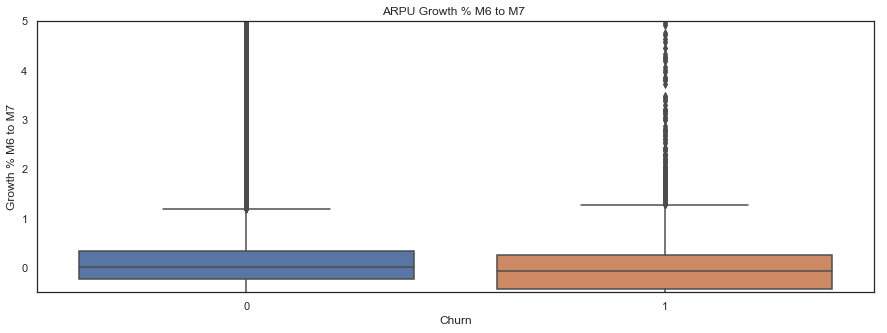

In [28]:
### Churn/No Churn pattern based on arpu percent growth 
churned=telecom_hv.loc[(telecom_hv.Churn == 1)]
notchurned=telecom_hv.loc[(telecom_hv.Churn ==0)]

plt.figure(figsize=(15,5))
sns.boxplot(x='Churn',y='per_arpu_6_7', data=telecom_hv) 
plt.title("ARPU Growth % M6 to M7 ")
plt.ylabel("Growth % M6 to M7")

plt.ylim(-0.5,5)

### Churned customers show a median of low % growth compared to not churned customers for ARPU.

(-0.5, 5)

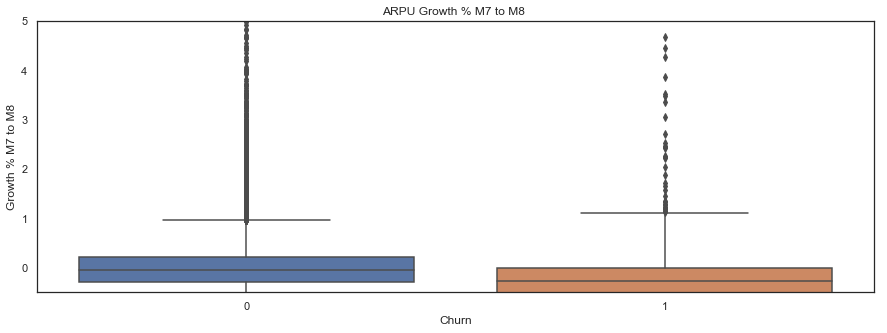

In [29]:
plt.figure(figsize=(15,5))
sns.boxplot(x='Churn',y='per_arpu_7_8', data=telecom_hv) 
plt.title("ARPU Growth % M7 to M8 ")
plt.ylabel("Growth % M7 to M8")

plt.ylim(-0.5,5)

### Churned customers show a median of low % growth compared to not churned customers for ARPU from M7 to M8.

(-0.5, 5)

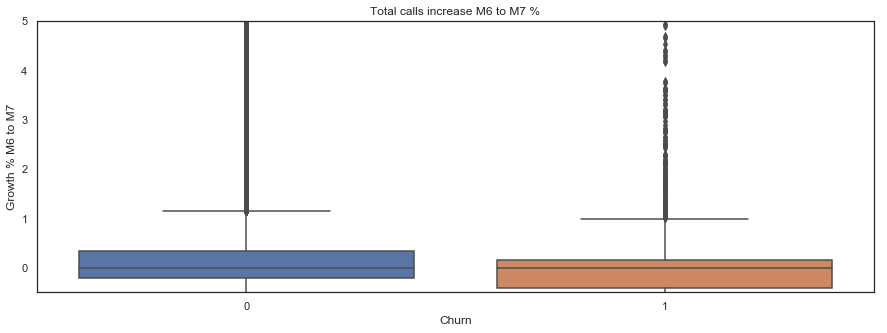

In [30]:
### Churn/No Churn pattern based on total calls months 6-7, 7-8

plt.figure(figsize=(15,5))
sns.boxplot(x='Churn',y='per_growth_6_7', data=telecom_hv) 
plt.title("Total calls increase M6 to M7 %")
plt.ylabel("Growth % M6 to M7")

plt.ylim(-0.5,5)

## Median growth % seems comparable for churned and not churned customers from M6 to M7

(-2, 2)

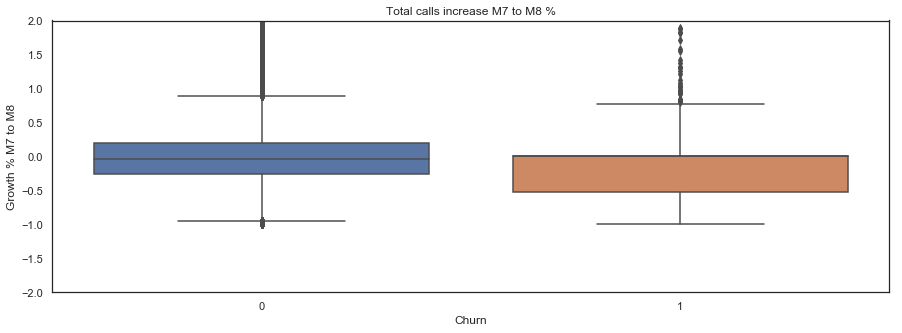

In [31]:
plt.figure(figsize=(15,5))
sns.boxplot(x='Churn',y='per_growth_7_8', data=telecom_hv) 
plt.title("Total calls increase M7 to M8 %")
plt.ylabel("Growth % M7 to M8")

plt.ylim(-2,2)

## Median growth % seems comparable for churned and not churned customers from M7 to M8 .
### but in general the % growth of majority of customers is less.


In [32]:
### Churn/No Churn pattern based on data usage 6-7, 7-8 
churned[['per_growth_6_7_data', 'per_growth_7_8_data']].describe()

,per_growth_6_7_data,per_growth_7_8_data
count,2589.000000,2589.000000
mean,4.092312,3.681406
std,168.561587,183.205707
min,-0.998769,-0.999926
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,8480.000000,9320.285714


In [33]:
notchurned[['per_growth_6_7_data', 'per_growth_7_8_data']].describe()

,per_growth_6_7_data,per_growth_7_8_data
count,27390.000000,27390.000000
mean,11.611238,7.035318
std,747.154592,544.497472
min,-0.999989,-0.999968
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,76812.000000,64051.000000


% growth is 4 % for churned customers from M6 to M7 compared to 11% for not churned.
% growth is 3% for churned customers from M7 to M8 compared to 7% for not churned. 
Above are based on mean.

#### Predictor and Dependent Variable split

In [34]:
# splitting train data into X and y
X = telecom_hv.drop("Churn", axis = 1)
y = telecom_hv['Churn']

### Principal Component Analysis

In [35]:
#Importing the PCA module
from sklearn.decomposition import PCA
pca = PCA(svd_solver='randomized', random_state=42)

In [36]:
#Doing the PCA onthe numerical dataset
pca.fit(X)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=42,
  svd_solver='randomized', tol=0.0, whiten=False)

In [37]:
### Dataframe containing PC values - PC1 & 2  along with feature names.
colnames = list(X.columns)
pcs_df = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'Feature':colnames})
pcs_df.head(5)

,PC1,PC2,Feature
0,-0.029448,0.120467,arpu_6
1,-0.040145,0.147348,arpu_7
2,-0.040663,0.153266,arpu_8
3,-0.093166,0.069887,onnet_mou_6
4,-0.110236,0.090923,onnet_mou_7


#### Selection of number of PCA components - Scree Plot

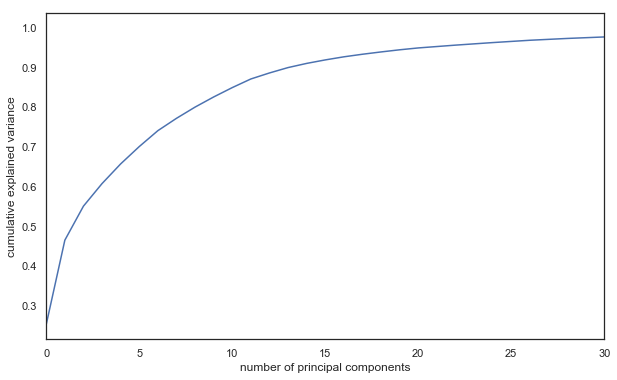

In [38]:
#Making the screeplot - plotting the cumulative variance against the number of components

plt.figure(figsize = (10,6))
plt.plot(np.cumsum(pca.explained_variance_ratio_) )
plt.xlabel('number of principal components')
plt.ylabel('cumulative explained variance')
plt.xlim(0,30)
plt.show()

### > 90% variance can be captured by 15 principal components.

In [39]:
from sklearn.decomposition import IncrementalPCA
pca_final = IncrementalPCA(n_components=15)

In [40]:
## Fit the numerical data for pca transformation into 15 components
X_reduced=pca_final.fit_transform(X)

In [41]:
### creating correlation matrix for the principal components
corrmat = np.corrcoef(X_reduced.transpose())
corrmat_nodiag = corrmat - np.diagflat(corrmat.diagonal())
print("max corr:",corrmat_nodiag.max(), ", min corr: ", corrmat_nodiag.min(),)
# Correlations are close to 0 . 

max corr: 0.003256729464085912 , min corr:  -0.0012353140865380668


In [42]:
### Using stratifiedShuffleSplit to ensure there is no imbalance in test , train split.
### 70% of data used for model test.
stratifiedcv = StratifiedShuffleSplit(n_splits=10, test_size=0.3, random_state=0)

### Build Model

#### Random Forest without PCA

In [43]:
# Importing random forest classifier from sklearn library
from sklearn.ensemble import RandomForestClassifier

# Running the random forest with default parameters.
rfc = RandomForestClassifier()

In [44]:
hyper_params = {'max_depth': range(2, 20, 5)}

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101,stratify=y)

# set up GridSearchCV()
model_cv = GridSearchCV(estimator = rfc, 
                        n_jobs=3,
                        param_grid = hyper_params, 
                        scoring= 'recall', 
                        cv = stratifiedcv, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
model_cv.fit(X_train, y_train)    

Fitting 10 folds for each of 4 candidates, totalling 40 fits


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  40 out of  40 | elapsed:   20.8s finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.3,
            train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=3,
       param_grid={'max_depth': range(2, 20, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score=True, scoring='recall', verbose=1)

In [45]:
# Making predictions
predictions = model_cv.predict(X_test)

In [47]:
# Importing classification report and confusion matrix from sklearn metrics
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score,precision_score,recall_score

In [48]:
print(recall_score(y_test,predictions))

0.4723294723294723


In [50]:
# printing the optimal recall score and hyperparameters
print('We can get recall of',model_cv.best_score_,'using',model_cv.best_params_)

We can get recall of 0.4770220588235294 using {'max_depth': 12}


### Hyperparameter Tuning

In [51]:
###### MAX DEPTH Tuning  ########

parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=stratifiedcv, 
                   scoring="recall")
rf.fit(X_train, y_train)

GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.3,
            train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': range(2, 20, 5)}, pre_dispatch='2*n_jobs',
       refit=True, return_train_score='warn', scoring='recall', verbose=0)

In [52]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.333359,0.025123,0.031745,0.001432,2,{'max_depth': 2},0.426471,0.485294,0.441176,0.395221,0.215074,0.487132,0.477941,0.468750,0.380515,0.498162,0.427574,0.080435,4,0.449527,0.502366,0.425079,0.425079,0.240536,0.506309,0.466877,0.434543,0.424290,0.522871,0.439748,0.075149
1,0.848347,0.035271,0.033340,0.002945,7,{'max_depth': 7},0.476103,0.454044,0.487132,0.474265,0.485294,0.481618,0.472426,0.488971,0.466912,0.476103,0.476287,0.009949,1,0.537855,0.548896,0.537066,0.526814,0.542587,0.536278,0.531546,0.517350,0.546530,0.545741,0.537066,0.009278
2,1.291940,0.071157,0.042722,0.007409,12,{'max_depth': 12},0.465074,0.465074,0.487132,0.474265,0.490809,0.457721,0.459559,0.494485,0.472426,0.468750,0.473529,0.012391,2,0.745268,0.775237,0.756309,0.738959,0.763407,0.726341,0.722397,0.732650,0.756309,0.768139,0.748502,0.017233
3,1.570137,0.088166,0.047928,0.009425,17,{'max_depth': 17},0.443015,0.439338,0.485294,0.465074,0.472426,0.466912,0.433824,0.481618,0.441176,0.444853,0.457353,0.018026,3,0.888013,0.893533,0.888801,0.878549,0.891956,0.891956,0.884069,0.885647,0.897476,0.884069,0.888407,0.005258


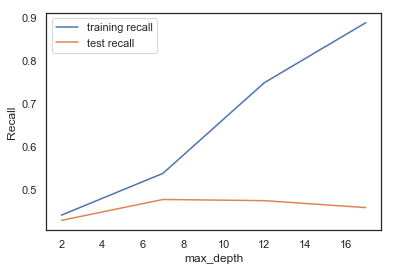

In [53]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training recall")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test recall")
plt.xlabel("max_depth")
plt.ylabel("Recall")
plt.legend()
plt.show()


### 4 or 6 seems optimal depth.

In [54]:
# printing the optimal recall score and hyperparameters
print('We can get recall of',rf.best_score_,'using',rf.best_params_)

We can get recall of 0.4762867647058823 using {'max_depth': 7}


#### Build GridsearchCV model with all hyperparameters for tuning 

In [56]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,6,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [50,250, 350], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = stratifiedcv, n_jobs = -1,verbose = 1, scoring='recall')

In [57]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 15.7min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.3,
            train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 6, 10], 'min_samples_leaf': range(100, 400, 200), 'min_samples_split': range(200, 500, 200), 'n_estimators': [50, 250, 350], 'max_features': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [58]:
# printing the optimal recall score and hyperparameters
print('We can get recall of',grid_search.best_score_,'using',grid_search.best_params_)

We can get recall of 0.4498161764705883 using {'max_depth': 6, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 400, 'n_estimators': 50}


### RandomForest with PCA

In [179]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.30, random_state=101,stratify=y)

param_grid = {
    'max_depth': [4,6,10],
    'min_samples_leaf': range(100, 400, 200),
    'min_samples_split': range(200, 500, 200),
    'n_estimators': [50,250, 350], 
    'max_features': [5, 10]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search_pca = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = stratifiedcv, n_jobs = -1,verbose = 1, scoring='recall')

# Fit the grid search to the data
grid_search_pca.fit(X_train, y_train)

Fitting 10 folds for each of 72 candidates, totalling 720 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed: 14.7min
[Parallel(n_jobs=-1)]: Done 720 out of 720 | elapsed: 29.5min finished


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=10, random_state=0, test_size=0.3,
            train_size=None),
       error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'max_depth': [4, 6, 10], 'min_samples_leaf': range(100, 400, 200), 'min_samples_split': range(200, 500, 200), 'n_estimators': [50, 250, 350], 'max_features': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [181]:
# printing the optimal recall score and hyperparameters
print('We can get recall of',grid_search_pca.best_score_,'using',grid_search_pca.best_params_)

We can get recall of 0.1170955882352941 using {'max_depth': 6, 'max_features': 10, 'min_samples_leaf': 100, 'min_samples_split': 200, 'n_estimators': 50}


### Build model using best scores - random forest without PCA

In [184]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101,stratify=y)

In [185]:
rfc_bestmodel = RandomForestClassifier(bootstrap=True,
                             max_depth=6,
                             min_samples_leaf=100, 
                             min_samples_split=400,
                             max_features=10,
                             n_estimators=50)

In [186]:
# Fit the grid search to the data
rfc_bestmodel.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=6, max_features=10, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=400,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [187]:
# Making predictions
predictions = rfc_bestmodel.predict(X_test)

In [188]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.95      0.98      0.97      8217
           1       0.74      0.46      0.57       777

   micro avg       0.94      0.94      0.94      8994
   macro avg       0.85      0.72      0.77      8994
weighted avg       0.93      0.94      0.93      8994



In [189]:
print(precision_score(y_test,predictions))

0.7427385892116183


In [190]:
print(recall_score(y_test,predictions))

0.46074646074646075


#### Model performance:
Recall : 45% on test data ; 46% on Train data 


###  Logistic Regression with RFE

To identify the key parameters that can help predict the high-value customer churn

In [191]:
## Checking outliers 

# Checking for outliers in the continuous variables
num_telecom = telecom_hv[['arpu_6','arpu_7','arpu_8','onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8','roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8']]
num_telecom.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8
count,29979.000000,29979.000000,29979.000000,29979.00000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000,29979.000000
mean,587.587624,589.424681,535.067748,296.23634,304.591922,267.809147,418.127743,424.103446,375.159926,17.428073,13.535270,13.263074,29.348362,22.056425,21.483542,94.733562,95.787420,87.184563,181.336751,181.323574,167.616746
std,442.848876,463.049067,492.447887,460.94123,481.966821,466.750205,470.773248,486.710075,477.656991,79.192826,76.343222,74.588105,118.629898,97.974803,106.294911,236.960935,248.250149,234.833442,250.231261,240.815912,234.896621
min,-2258.709000,-2014.045000,-945.808000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,364.352500,365.235000,289.782000,41.17000,41.045000,27.070000,137.340000,135.690000,95.730000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.330000,9.130000,5.790000,30.290000,33.580000,22.420000
50%,495.951000,493.781000,452.232000,125.89000,125.560000,99.590000,282.260000,282.040000,241.040000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,32.610000,33.190000,28.640000,101.280000,104.360000,89.880000
75%,704.184500,700.986000,671.349500,353.50000,360.360000,298.215000,523.625000,532.905000,483.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,91.550000,91.535000,84.700000,240.230000,239.485000,223.615000
90%,994.311800,996.051400,985.499200,795.35400,825.486000,724.182000,916.490000,935.716000,854.006000,32.740000,18.390000,18.664000,64.604000,41.216000,37.150000,208.006000,207.880000,196.948000,435.364000,437.920000,416.982000
95%,1240.976700,1261.848400,1258.703300,1154.90000,1208.691000,1115.857000,1271.757000,1287.221000,1188.523000,94.663000,63.422000,62.813000,168.647000,119.447000,114.900000,348.694000,346.993000,324.162000,615.120000,608.183000,585.086000
99%,1983.590100,1999.509680,1988.082260,2166.87600,2220.577600,2189.445800,2328.192600,2411.004400,2212.303000,349.546000,292.851400,288.536400,544.085400,448.174000,432.999600,1076.635600,1060.354600,956.750000,1147.821600,1112.863600,1092.917000


In [192]:
### Removing outliers 
Q1 = telecom_hv.arpu_6.quantile(0.25)
Q3 = telecom_hv.arpu_6.quantile(0.75)
IQR = Q3 - Q1
telecom_hv_removeoutlier = telecom_hv[(X.arpu_6 >= Q1 - 1.5*IQR) & (telecom_hv.arpu_6 <= Q3 + 1.5*IQR)]

In [193]:
Q1 = telecom_hv_removeoutlier.arpu_7.quantile(0.25)
Q3 = telecom_hv_removeoutlier.arpu_7.quantile(0.75)
IQR = Q3 - Q1
telecom_hv_removeoutlier = telecom_hv_removeoutlier[(telecom_hv_removeoutlier.arpu_7 >= Q1 - 1.5*IQR) & (telecom_hv_removeoutlier.arpu_7 <= Q3 + 1.5*IQR)]

In [194]:
Q1 = telecom_hv_removeoutlier.arpu_8.quantile(0.25)
Q3 = telecom_hv_removeoutlier.arpu_8.quantile(0.75)
IQR = Q3 - Q1
telecom_hv_removeoutlier = telecom_hv_removeoutlier[(telecom_hv_removeoutlier.arpu_8 >= Q1 - 1.5*IQR) & (telecom_hv_removeoutlier.arpu_8 <= Q3 + 1.5*IQR)]

In [195]:
Q1 = telecom_hv_removeoutlier.onnet_mou_6.quantile(0.25)
Q3 = telecom_hv_removeoutlier.onnet_mou_6.quantile(0.75)
IQR = Q3 - Q1
telecom_hv_removeoutlier = telecom_hv_removeoutlier[(telecom_hv_removeoutlier.onnet_mou_6 >= Q1 - 1.5*IQR) & (telecom_hv_removeoutlier.onnet_mou_6 <= Q3 + 1.5*IQR)]

In [196]:
Q1 = telecom_hv_removeoutlier.roam_ic_mou_6.quantile(0.25)
Q3 = telecom_hv_removeoutlier.roam_ic_mou_6.quantile(0.75)
IQR = Q3 - Q1
telecom_hv_removeoutlier = telecom_hv_removeoutlier[(telecom_hv_removeoutlier.roam_ic_mou_6 >= Q1 - 1.5*IQR) & (telecom_hv_removeoutlier.roam_ic_mou_6 <= Q3 + 1.5*IQR)]

In [197]:
telecom_hv_removeoutlier.shape
## retaining ~70% data 

(18348, 164)

In [198]:
num_telecom = telecom_hv_removeoutlier[['arpu_6','arpu_7','arpu_8','onnet_mou_6','onnet_mou_7','onnet_mou_8','offnet_mou_6','offnet_mou_7','offnet_mou_8','roam_ic_mou_6','roam_ic_mou_7','roam_ic_mou_8','roam_og_mou_6','roam_og_mou_7','roam_og_mou_8','loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8']]
num_telecom.describe(percentiles=[.25, .5, .75, .90, .95, .99])

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8
count,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.0,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000
mean,484.888166,484.086624,430.712005,165.277480,182.617951,161.909439,384.047637,368.693724,315.349160,0.0,3.789561,5.648134,0.174542,6.375710,8.373719,75.883529,76.847783,70.477866,189.509456,181.564447,163.518684
std,206.976480,197.449274,233.600074,180.491514,248.928346,246.591194,363.684940,339.180726,315.684643,0.0,25.505137,39.582658,3.316713,33.834895,42.915759,108.419174,136.437184,138.430821,217.916960,203.462174,194.637188
min,-124.766000,-76.429000,-197.957000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,347.361750,349.226250,275.117250,32.180000,31.255000,21.510000,140.270000,137.727500,95.905000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,9.940000,9.690000,6.230000,39.730000,39.510000,26.887500
50%,448.944000,450.137500,409.102500,95.460000,92.135000,74.410000,280.730000,273.495000,228.540000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,35.630000,33.930000,29.160000,123.310000,118.885000,99.905000
75%,592.613750,594.190250,571.301500,234.535000,232.460000,196.867500,503.045000,489.757500,432.830000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,94.832500,89.865000,82.415000,263.700000,251.987500,231.117500
90%,770.746700,763.419500,754.048700,455.640000,484.858000,429.233000,834.666000,805.884000,711.569000,0.0,0.600000,4.266000,0.000000,1.600000,8.490000,197.160000,189.711000,178.205000,441.366000,428.626000,402.996000
95%,891.151150,872.939300,863.604700,581.055500,670.815000,627.034000,1116.360000,1054.113000,939.160000,0.0,14.880000,22.599500,0.000000,32.412000,43.307500,297.652500,290.370000,266.114500,595.026500,570.243500,535.330500
99%,1092.964200,1038.710220,1030.552280,717.786500,1123.330100,1155.892100,1771.227600,1622.187400,1506.187200,0.0,94.764200,122.914800,2.522400,163.727600,195.467600,552.075400,611.084000,562.251200,1009.915400,954.610500,888.926400


In [199]:
telecom_hv_removeoutlier.describe()

,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,offnet_mou_7,offnet_mou_8,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,loc_og_t2c_mou_6,loc_og_t2c_mou_7,loc_og_t2c_mou_8,loc_og_mou_6,loc_og_mou_7,loc_og_mou_8,std_og_t2t_mou_6,std_og_t2t_mou_7,std_og_t2t_mou_8,std_og_t2m_mou_6,std_og_t2m_mou_7,std_og_t2m_mou_8,std_og_t2f_mou_6,std_og_t2f_mou_7,std_og_t2f_mou_8,std_og_mou_6,std_og_mou_7,std_og_mou_8,isd_og_mou_6,isd_og_mou_7,isd_og_mou_8,spl_og_mou_6,spl_og_mou_7,spl_og_mou_8,og_others_6,og_others_7,og_others_8,total_og_mou_6,total_og_mou_7,total_og_mou_8,loc_ic_t2t_mou_6,loc_ic_t2t_mou_7,loc_ic_t2t_mou_8,loc_ic_t2m_mou_6,loc_ic_t2m_mou_7,loc_ic_t2m_mou_8,loc_ic_t2f_mou_6,loc_ic_t2f_mou_7,loc_ic_t2f_mou_8,loc_ic_mou_6,loc_ic_mou_7,loc_ic_mou_8,std_ic_t2t_mou_6,std_ic_t2t_mou_7,std_ic_t2t_mou_8,std_ic_t2m_mou_6,std_ic_t2m_mou_7,std_ic_t2m_mou_8,std_ic_t2f_mou_6,std_ic_t2f_mou_7,std_ic_t2f_mou_8,std_ic_mou_6,std_ic_mou_7,std_ic_mou_8,total_ic_mou_6,total_ic_mou_7,total_ic_mou_8,spl_ic_mou_6,spl_ic_mou_7,spl_ic_mou_8,isd_ic_mou_6,isd_ic_mou_7,isd_ic_mou_8,ic_others_6,ic_others_7,ic_others_8,total_rech_num_6,total_rech_num_7,total_rech_num_8,total_rech_amt_6,total_rech_amt_7,total_rech_amt_8,max_rech_amt_6,max_rech_amt_7,max_rech_amt_8,last_day_rch_amt_6,last_day_rch_amt_7,last_day_rch_amt_8,total_rech_data_6,total_rech_data_7,total_rech_data_8,max_rech_data_6,max_rech_data_7,max_rech_data_8,count_rech_2g_6,count_rech_2g_7,count_rech_2g_8,count_rech_3g_6,count_rech_3g_7,count_rech_3g_8,av_rech_amt_data_6,av_rech_amt_data_7,av_rech_amt_data_8,vol_2g_mb_6,vol_2g_mb_7,vol_2g_mb_8,vol_3g_mb_6,vol_3g_mb_7,vol_3g_mb_8,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_2g_6,arpu_2g_7,arpu_2g_8,night_pck_user_6,night_pck_user_7,night_pck_user_8,monthly_2g_6,monthly_2g_7,monthly_2g_8,sachet_2g_6,sachet_2g_7,sachet_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8,sachet_3g_6,sachet_3g_7,sachet_3g_8,fb_user_6,fb_user_7,fb_user_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,Total_mou_6,Total_mou_7,Total_mou_8,per_growth_6_7,per_growth_7_8,total_vol_6,total_vol_7,total_vol_8,per_growth_6_7_data,per_growth_7_8_data,per_arpu_6_7,per_arpu_7_8,Churn
count,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.0,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.00000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.00000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.00000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,18348.000000,

In [200]:
### Drop roam_ic_mou_7
telecom_hv_removeoutlier.drop('roam_ic_mou_7',axis=1,inplace=True)

In [201]:
### Split X, y
X_lr=telecom_hv_removeoutlier.drop("Churn",axis=1)
y_lr=telecom_hv_removeoutlier.Churn

In [202]:
#X_lr.shape
y_lr.shape

(18348,)

In [203]:
# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X_lr, y_lr, test_size=0.30, random_state=101, stratify=y_lr)

## Feature Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train[X_train.select_dtypes(exclude=['int64']).columns]=scaler.fit_transform(X_train[X_train.select_dtypes(exclude=['int64']).columns])

In [204]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [205]:
#### Selecting 15 parameters through RFE #######
from sklearn.feature_selection import RFE
rfe = RFE(logreg, 15)     

In [206]:
rfe = rfe.fit(X_train, y_train)

In [207]:
col = X_train.columns[rfe.support_]

In [208]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                12843
Model:                            GLM   Df Residuals:                    12827
Model Family:                Binomial   Df Model:                           15
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2211.0
Date:                Mon, 13 May 2019   Deviance:                       4422.0
Time:                        20:58:45   Pearson chi2:                 1.82e+05
No. Iterations:                    12   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.3142      0.125    -34.473      0.000      -4.559      -4.069
arpu_8              -0.7690      0.064    -11.993      0.000      -0.895      -0.643
onnet_mou_8          0.8535      0.257      3.317      0.001       0.349       1.358
loc_og_mou_8        -1.3658      0.187     -7.291      0.000      -1.733      -0.999
std_og_t2t_mou_8    -1.0105      0.230     -4.388      0.000      -1.462      -0.559
og_others_8         -2.8949      3.212     -0.901      0.367      -9.190       3.401
loc_ic_t2m_mou_7     0.8008      0.088      9.145      0.000       0.629       0.972
loc_ic_t2m_mou_8    -1.1937      0.360     -3.317      0.001      -1.899      -0.488
loc_ic_mou_8        -1.2355      0.338     -3.655      0.000      -1.898      -0.573
std_ic_t2f_mou_8    -0.7881      0.318     -2.480      0.013      -1.411      -0.165
spl_ic_mou_8        -0.7241      0.127     -5.695      0.000      -0.973      -0.475
count_rech_2g_7     -0.0030      0.039     -0.077      0.938      -0.080       0.074
monthly_2g_7        -0.2444      0.152     -1.611      0.107      -0.542       0.053
monthly_2g_8        -1.1477      0.261     -4.391      0.000      -1.660      -0.635
monthly_3g_8        -1.0832      0.203     -5.327      0.000      -1.482      -0.685
sachet_3g_8         -0.5033      0.173     -2.912      0.004      -0.842      -0.165
====================================================================================
"""

In [209]:
# Getting the predicted values on the train set
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

31499    0.000062
60101    0.000050
99416    0.165720
55355    0.003755
91511    0.006158
12290    0.003011
4449     0.000095
26891    0.003039
47813    0.004874
65665    0.543378
dtype: float64

In [210]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([6.19306154e-05, 4.96836357e-05, 1.65720471e-01, 3.75463501e-03,
       6.15812896e-03, 3.01091242e-03, 9.51777637e-05, 3.03871619e-03,
       4.87350232e-03, 5.43377577e-01])

In [211]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

,Churn,Churn_Prob,CustID
0,0,0.000062,31499
1,0,0.000050,60101
2,0,0.165720,99416
3,1,0.003755,55355
4,0,0.006158,91511


In [222]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)

In [223]:
print(metrics.recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.788961038961039


#### Checking for VIF

In [214]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [215]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
3,std_og_t2t_mou_8,6.36
1,onnet_mou_8,6.34
6,loc_ic_t2m_mou_8,5.43
7,loc_ic_mou_8,3.60
2,loc_og_mou_8,3.02
5,loc_ic_t2m_mou_7,2.92
11,monthly_2g_7,1.69
12,monthly_2g_8,1.69
0,arpu_8,1.68
13,monthly_3g_8,1.14


In [216]:
########### model 2 - Logistic Regression with RFE ###################
col=col.drop('std_og_t2t_mou_8', 1)
X_train_sm = sm.add_constant(X_train[col])
logm3 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res3 = logm3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                12843
Model:                            GLM   Df Residuals:                    12828
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2219.4
Date:                Mon, 13 May 2019   Deviance:                       4438.8
Time:                        20:59:09   Pearson chi2:                 2.48e+05
No. Iterations:                    12   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.3101      0.126    -34.330      0.000      -4.556      -4.064
arpu_8              -0.7614      0.065    -11.710      0.000      -0.889      -0.634
onnet_mou_8         -0.2486      0.072     -3.449      0.001      -0.390      -0.107
loc_og_mou_8        -0.9546      0.155     -6.153      0.000      -1.259      -0.651
og_others_8         -2.9076      3.224     -0.902      0.367      -9.226       3.411
loc_ic_t2m_mou_7     0.8364      0.088      9.521      0.000       0.664       1.009
loc_ic_t2m_mou_8    -1.6001      0.342     -4.677      0.000      -2.271      -0.930
loc_ic_mou_8        -0.9681      0.318     -3.048      0.002      -1.591      -0.346
std_ic_t2f_mou_8    -0.8022      0.319     -2.516      0.012      -1.427      -0.177
spl_ic_mou_8        -0.7319      0.128     -5.740      0.000      -0.982      -0.482
count_rech_2g_7     -0.0019      0.039     -0.048      0.962      -0.078       0.075
monthly_2g_7        -0.2299      0.152     -1.515      0.130      -0.527       0.068
monthly_2g_8        -1.1414      0.262     -4.363      0.000      -1.654      -0.629
monthly_3g_8        -1.0848      0.203     -5.334      0.000      -1.483      -0.686
sachet_3g_8         -0.5001      0.172     -2.911      0.004      -0.837      -0.163
====================================================================================
"""

In [217]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
5,loc_ic_t2m_mou_8,5.22
6,loc_ic_mou_8,3.49
4,loc_ic_t2m_mou_7,2.92
10,monthly_2g_7,1.69
11,monthly_2g_8,1.68
2,loc_og_mou_8,1.59
0,arpu_8,1.55
1,onnet_mou_8,1.25
12,monthly_3g_8,1.12
9,count_rech_2g_7,1.08


In [224]:
### Predicting using model2 
# Getting the predicted values on the train set
y_train_pred2 = res3.predict(X_train_sm)
y_train_pred_final2 = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final2['CustID'] = y_train.index
y_train_pred_final2['predicted'] = y_train_pred_final2.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)

In [225]:
print(metrics.recall_score(y_train_pred_final2.Churn, y_train_pred_final2.predicted))

0.788961038961039


In [226]:
col=col.drop('loc_ic_t2m_mou_8', 1)
col

Index(['arpu_8', 'onnet_mou_8', 'loc_og_mou_8', 'og_others_8',
       'loc_ic_t2m_mou_7', 'loc_ic_mou_8', 'std_ic_t2f_mou_8', 'spl_ic_mou_8',
       'count_rech_2g_7', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_8',
       'sachet_3g_8'],
      dtype='object')

In [227]:
########### model 3 - Logistic Regression with RFE ###################
X_train_sm = sm.add_constant(X_train[col])
logm4 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res4 = logm4.fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                12843
Model:                            GLM   Df Residuals:                    12829
Model Family:                Binomial   Df Model:                           13
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2229.2
Date:                Mon, 13 May 2019   Deviance:                       4458.3
Time:                        21:00:12   Pearson chi2:                 2.01e+05
No. Iterations:                    12   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.3229      0.126    -34.196      0.000      -4.571      -4.075
arpu_8              -0.7851      0.065    -12.037      0.000      -0.913      -0.657
onnet_mou_8         -0.2282      0.071     -3.206      0.001      -0.368      -0.089
loc_og_mou_8        -0.9909      0.156     -6.353      0.000      -1.297      -0.685
og_others_8         -2.9965      3.290     -0.911      0.362      -9.445       3.452
loc_ic_t2m_mou_7     0.7089      0.081      8.713      0.000       0.549       0.868
loc_ic_mou_8        -2.3263      0.216    -10.784      0.000      -2.749      -1.904
std_ic_t2f_mou_8    -0.7762      0.315     -2.463      0.014      -1.394      -0.158
spl_ic_mou_8        -0.7361      0.128     -5.764      0.000      -0.986      -0.486
count_rech_2g_7     -0.0051      0.039     -0.130      0.897      -0.081       0.071
monthly_2g_7        -0.2253      0.151     -1.488      0.137      -0.522       0.072
monthly_2g_8        -1.1195      0.261     -4.290      0.000      -1.631      -0.608
monthly_3g_8        -1.0818      0.204     -5.314      0.000      -1.481      -0.683
sachet_3g_8         -0.4955      0.171     -2.901      0.004      -0.830      -0.161
====================================================================================
"""

In [229]:
### Predicting using model3
# Getting the predicted values on the train set
y_train_pred3 = res4.predict(X_train_sm)
y_train_pred_final3 = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final3['CustID'] = y_train.index
y_train_pred_final3['predicted'] = y_train_pred_final3.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)

In [230]:
print(metrics.recall_score(y_train_pred_final3.Churn, y_train_pred_final3.predicted))

0.788961038961039


In [231]:
### Final Model - Based on manual analysis and RFE ####################
X_train_sm=X_train[['arpu_8', 'onnet_mou_8', 'loc_og_mou_8', 'og_others_8',
        'loc_ic_t2m_mou_7', 'loc_ic_mou_8', 'std_ic_t2f_mou_8',
       'spl_ic_mou_8', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_8',
       'sachet_3g_8']]
col=['arpu_8', 'onnet_mou_8', 'loc_og_mou_8', 'og_others_8',
        'loc_ic_t2m_mou_7', 'loc_ic_mou_8', 'std_ic_t2f_mou_8',
       'spl_ic_mou_8', 'monthly_2g_7', 'monthly_2g_8', 'monthly_3g_8',
       'sachet_3g_8']

In [232]:
### Final Model - Based on manaual analysis ####################
X_train_sm = sm.add_constant(X_train_sm)
logm5 = sm.GLM(y_train,X_train_sm, family = sm.families.Binomial())
res5 = logm5.fit()
res5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  Churn   No. Observations:                12843
Model:                            GLM   Df Residuals:                    12830
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2229.2
Date:                Mon, 13 May 2019   Deviance:                       4458.3
Time:                        21:00:29   Pearson chi2:                 2.01e+05
No. Iterations:                    12   Covariance Type:             nonrobust
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -4.3226      0.126    -34.196      0.000      -4.570      -4.075
arpu_8              -0.7856      0.065    -12.058      0.000      -0.913      -0.658
onnet_mou_8         -0.2276      0.071     -3.204      0.001      -0.367      -0.088
loc_og_mou_8        -0.9901      0.156     -6.353      0.000      -1.296      -0.685
og_others_8         -2.9978      3.290     -0.911      0.362      -9.447       3.451
loc_ic_t2m_mou_7     0.7090      0.081      8.715      0.000       0.550       0.868
loc_ic_mou_8        -2.3273      0.216    -10.794      0.000      -2.750      -1.905
std_ic_t2f_mou_8    -0.7760      0.315     -2.462      0.014      -1.394      -0.158
spl_ic_mou_8        -0.7362      0.128     -5.764      0.000      -0.987      -0.486
monthly_2g_7        -0.2275      0.150     -1.512      0.130      -0.522       0.067
monthly_2g_8        -1.1195      0.261     -4.290      0.000      -1.631      -0.608
monthly_3g_8        -1.0805      0.203     -5.314      0.000      -1.479      -0.682
sachet_3g_8         -0.4977      0.170     -2.925      0.003      -0.831      -0.164
====================================================================================
"""

In [234]:
y_train_pred4 = res5.predict(X_train_sm)
y_train_pred_final4 = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final4['CustID'] = y_train.index
y_train_pred_final4['predicted'] = y_train_pred_final4.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)

In [235]:
print(metrics.recall_score(y_train_pred_final4.Churn, y_train_pred_final4.predicted))

0.788961038961039


In [237]:
print(metrics.precision_score(y_train_pred_final4.Churn, y_train_pred_final4.predicted))

0.2773972602739726


In [238]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

### No multicolinearity seen now.

,Features,VIF
5,loc_ic_mou_8,2.11
4,loc_ic_t2m_mou_7,1.93
9,monthly_2g_8,1.68
8,monthly_2g_7,1.67
2,loc_og_mou_8,1.59
0,arpu_8,1.53
1,onnet_mou_8,1.23
10,monthly_3g_8,1.11
11,sachet_3g_8,1.02
6,std_ic_t2f_mou_8,1.01


#### Model Peformance :
on Train data -> ~78% Recall and ~28% precision 

#### Finding the right cut-off

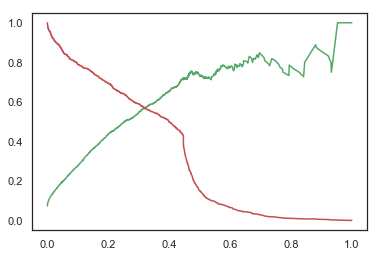

In [239]:
from sklearn.metrics import precision_recall_curve
p, r, thresholds = precision_recall_curve(y_train_pred_final4.Churn, y_train_pred_final4.Churn_Prob)
plt.plot(thresholds, p[:-1], "g-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()

In [240]:
numbers = [float(x)/10 for x in range(10)]
for i in numbers:
    y_train_pred_final4[i]= y_train_pred_final4.Churn_Prob.map(lambda x: 1 if x > i else 0)
y_train_pred_final4.head()
# calculate accuracy sensitivity and specificity for various probability cutoffs.
cutoff_df = pd.DataFrame( columns = ['prob','accuracy','sensi','speci'])
from sklearn.metrics import confusion_matrix

num = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
for i in num:
    cm1 = metrics.confusion_matrix(y_train_pred_final4.Churn, y_train_pred_final4[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_df.loc[i] =[ i ,accuracy,sensi,speci]

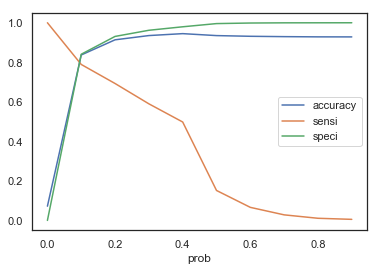

In [241]:
cutoff_df.plot.line(x='prob', y=['accuracy','sensi','speci'])
plt.show()

#### Since the focus here is on recall, 0.1 is chose as the cut off for better model performance. 

#### Prediction on Test using final model - logistic Regression  

In [242]:
X_test[X_test.select_dtypes(exclude=['int64']).columns]=scaler.transform(X_test[X_test.select_dtypes(exclude=['int64']).columns])

In [243]:
X_test=X_test[col]
X_test_sm = sm.add_constant(X_test)
y_test_pred = res5.predict(X_test_sm)

In [254]:
y_test_pred_final4 = pd.DataFrame({'Churn':y_test.values, 'Churn_Prob':y_test_pred})
y_test_pred_final4['CustID'] = y_test.index
y_test_pred_final4['predicted'] = y_test_pred_final4.Churn_Prob.map(lambda x: 1 if x > 0.1 else 0)

In [255]:
print(metrics.recall_score(y_test_pred_final4.Churn, y_test_pred_final4.predicted))

0.7702020202020202


In [256]:
print(metrics.accuracy_score(y_test_pred_final4.Churn, y_test_pred_final4.predicted))

0.8305177111716622


#### Model Performance 
On Test data :
77% REcall 
83% accuracy 

### Important Predictor Parameters

<B>arpu_8</B> * -0.7856	+ <B>onnet_mou_8</B> * -0.2276	+ <B>loc_og_mou_8</B>	* -0.9901 + <B>og_others_8</B> * -2.9978 + <B>loc_ic_t2m_mou_7</B>* 0.7090 + <B>loc_ic_mou_8</B> * -2.3273 + <B>std_ic_t2f_mou_8</B> * -0.7760 + <B>spl_ic_mou_8</B> * -0.7362	+ <B>monthly_2g_7</B> * -0.2275 + <B>monthly_2g_8</B>	* -1.1195+ <B>monthly_3g_8</B> * -1.0805	+ <B>sachet_3g_8</B> * -0.4977	